In [108]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform, util, color
from pillclassification.feature_extraction import feature_extraction
import xml.etree.ElementTree as ET

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [109]:
# Load image

images_dir = Path('utils/Dataset/merge')
filenames = [x for x in images_dir.iterdir() if x.suffix != '.xml']
tree = ET.parse(images_dir / 'images.xml')
se = list(tree.getroot())[0]

X = []
Y = []

shapes = {
    'OVAL': 0,
    'ROUND': 1,
    'CAPSULE': 2,
    'TRIANGLE': 3,
    'PENTAGON': 5
}

for idx, filename in enumerate(filenames[:100]):
    image_orig = io.imread(filename)

    if image_orig.shape[-1] == 4:
        image_orig = image_orig[:,:,:3]

    crop_scale = 0.8

    def crop_center(img):
        y,x,d = img.shape
        cropx = int(x * crop_scale)
        cropy = int(y * crop_scale)
        startx = int(x/2-(cropx/2))
        starty = int(y/2-(cropy/2)) - 100 
        return img[starty:starty+cropy,startx:startx+cropx,:]

    height = 600
    image = crop_center(image_orig)
    image = transform.resize(image, (int(image.shape[0] * (height / image.shape[1])), height), anti_aliasing=True)
    image = util.img_as_float(image)
    # plt.figure(figsize=(10,10))
    # plt.imshow(image)
    # plt.show()

    hu, color = feature_extraction(image)
    
    image_xml = None
    for e in list(se):
        xml_el = e.find('File').find('Name')
        if xml_el is not None and xml_el.text == filename.name: 
            image_xml = e
            break
            
    if image_xml is None:
        print('What')
        break
    
    true_color = image_xml.find('Color').text
    true_shape = image_xml.find('Shape').text.split()[0]
    
    print('\r{:3}/{}: {} {}'.format(idx, 100, true_color, true_shape), end='')
    
    X.append(hu)
    Y.append(shapes[true_shape])

  0/100: BROWN OVAL
  1/100: WHITE ROUND
  2/100: WHITE OVAL
  3/100: YELLOW ROUND
  4/100: BLUE ROUND
  5/100: BROWN OVAL
  6/100: GREEN ROUND
  7/100: PINK PENTAGON
  8/100: BLUE ROUND
  9/100: ORANGE OVAL
 10/100: YELLOW OVAL
 11/100: WHITE OVAL
 12/100: PURPLE ROUND
 13/100: RED ROUND
 14/100: BLUE CAPSULE
 15/100: PURPLE ROUND
 16/100: YELLOW TRIANGLE
 17/100: PURPLE ROUND
 18/100: YELLOW PENTAGON
 19/100: RED OVAL
 20/100: GREEN ROUND
 21/100: RED TRIANGLE
 22/100: RED ROUND
 23/100: BLUE CAPSULE
 24/100: RED ROUND
 25/100: WHITE ROUND
 26/100: PINK OVAL
 27/100: YELLOW ROUND
 28/100: WHITE OVAL
 29/100: PINK OVAL
 30/100: YELLOW PENTAGON
 31/100: PINK PENTAGON
 32/100: PINK TRIANGLE
 33/100: BLUE ROUND
 34/100: PURPLE ROUND
 35/100: WHITE OVAL
 36/100: WHITE PENTAGON
 37/100: YELLOW OVAL
 38/100: WHITE ROUND
 39/100: WHITE ROUND
 40/100: RED ROUND
 41/100: YELLOW TRIANGLE
 42/100: YELLOW PENTAGON
 43/100: RED ROUND
 44/100: YELLOW OVAL
 45/100: WHITE ROUND
 46/100: PINK OVAL
 47

LinAlgError: SVD did not converge

In [68]:
tree = ET.parse(images_dir / 'images.xml')
se = list(tree.getroot())[0]
file = se.findall('.//File[Name="{}"]'.format(filename.name))[0]
print(file.get('Name'))

None
['ciao', 'c']


In [103]:
import pandas as pd
from sklearn import svm

clf = svm.SVC(kernel = 'linear', C = 1.0)
clf.fit(X, Y)

SVC(kernel='linear')

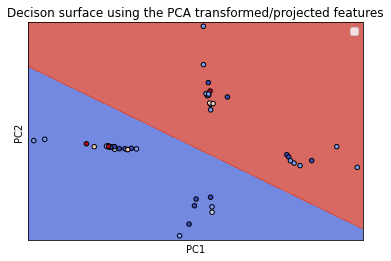

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = svm.SVC(kernel='linear')
clf = model.fit(Xreduced, Y)

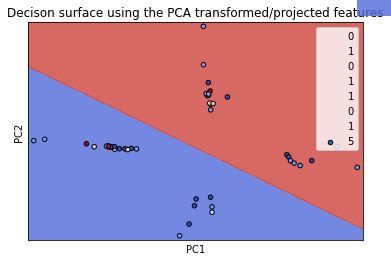

In [120]:
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend(Y)
plt.show()